In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

from Setting import Setting
from Dataset import Dataset
from Environment import Environment

import utils.models as models
import utils.metrics as metrics

torch.cuda.is_available()

False

# General settings

In [2]:
# Set the random seed for reproducibility.
random_seed = 1
#tf.random.set_random_seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

args = Setting()
args.windowed_dataset = True
device = args.device
dataset = Dataset(args.dataset_path, args.batch_size, args.fast_testing)
padding_number = dataset.num_items
env = Environment(args, dataset, padding_number).to(device)

# Import dataset

In [3]:
train_seq_base_data = env.train_seq_base_data
train_seq_base_data.shape

torch.Size([70829, 20])

In [4]:
test_seq_base_data = env.test_seq_base_data
test_seq_base_data.shape

torch.Size([14913, 20])

In [5]:
train_seq_target_data = env.train_seq_target_data
train_seq_target_data.shape

torch.Size([70829, 1])

In [6]:
train_base_data = env.train_base_data
train_base_data.shape

torch.Size([70829, 18])

In [7]:
test_base_data = env.test_base_data
test_base_data.shape

torch.Size([14913, 18])

In [8]:
true_train_data = train_base_data

In [9]:
true_test_data = test_base_data

In [10]:
train_target_data = env.train_target_data
train_target_data.shape

torch.Size([70829, 18])

In [11]:
test_target_data = env.test_target_data
test_target_data.shape

torch.Size([14913, 18])

In [12]:
true_train_data, masked_train_ref = env.mask_data(train_base_data, train_target_data)
print(true_train_data.shape)
print(masked_train_ref.shape)

torch.Size([70829, 18])
torch.Size([70829, 18])


In [13]:
true_test_data, masked_test_ref = env.mask_data(test_base_data, test_target_data)
print(true_test_data.shape)
print(masked_test_ref.shape)

torch.Size([14913, 18])
torch.Size([14913, 18])


# Matrix Factorization

In [14]:
learning_rate = 1e-3
weight_decay = 0.00
epochs = 20
n_users = dataset.n_users
n_categories = dataset.n_categories
emb_dim = 20
batch_size = 256

## Functions

In [15]:
def train_all_categories():
    N = len(train_seq_base_data)
    idxs = list(range(N))
    
    train_loss_list = []
    for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        batch_train_data = train_base_data[idxs[start_idx:end_idx]]
        batch_target_data = train_target_data[idxs[start_idx:end_idx]]
        batch_train_seq_data = train_seq_base_data[idxs[start_idx:end_idx]]
    
        batch_user_data = []
        for i in range(len(batch_train_seq_data)):
            user = int(batch_train_seq_data[i][0].item())
            user_data = []
            # For each user we add every possible category. In this way we
            # can compute the rating for each category of a user profile.
            for category in range(n_categories):
                user_data.append([user, category])
            user_data = torch.tensor(user_data).to(device)
            batch_user_data.append(user_data)
        batch_user_data = torch.vstack(batch_user_data).to(device)
        
        # We predict the rating for the categories.
        batch_recon_data = model(batch_user_data)
        # Since we have every possible category for each user, we can build 
        # user profiles.
        batch_recon_data = torch.reshape(batch_recon_data, (len(batch_train_seq_data), n_categories)).to(device)
        optimizer.zero_grad()
        # We compute the loss and update the parameters.
        loss = mse_loss(batch_recon_data, batch_target_data)
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    
    return train_loss_list

In [16]:
def evaluate():
    N = len(test_seq_base_data)
    idxs = list(range(N))
    
    recon_data = []
    test_loss_list = []
    for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        batch_test_data = test_base_data[idxs[start_idx:end_idx]]
        batch_target_data = test_target_data[idxs[start_idx:end_idx]]
        batch_test_seq_data = test_seq_base_data[idxs[start_idx:end_idx]]
    
        batch_user_data = []
        for i in range(len(batch_test_seq_data)):
            user = int(batch_test_seq_data[i][0].item())
            user_data = []
            # For each user we add every possible category. In this way we
            # can compute the rating for each category of a user profile.
            for category in range(n_categories):
                user_data.append([user, category])
            user_data = torch.tensor(user_data).to(device)
            batch_user_data.append(user_data)
        batch_user_data = torch.vstack(batch_user_data).to(device)
        
        # We predict the rating for the categories.
        batch_recon_data = model(batch_user_data)
        # Since we have every possible category for each user, we can build 
        # user profiles.
        batch_recon_data = torch.reshape(batch_recon_data.detach(), (len(batch_test_seq_data), n_categories)).to(device)
        # We compute the loss but we don't update the parameters.
        loss = mse_loss(batch_recon_data, batch_target_data)
        test_loss_list.append(loss.item())
        recon_data.append(batch_recon_data)
    recon_data = torch.vstack(recon_data).to(device)
    
    # We compute the RMSE values.
    rmse_total, rmse_explicit, rmse_implicit = metrics.rmse_with_mask(test_base_data, true_test_data, recon_data, test_target_data, masked_test_ref)
     
    return rmse_total, rmse_explicit, rmse_implicit, test_loss_list

# Train

In [17]:
model_name = 'mf'
total_time = time.time()

#######################################################################
# Build the model
#######################################################################
model = models.MatrixFactorization(n_users, n_categories, emb_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
mse_loss = models.CustomMSE(type="mse_loss")

#######################################################################
# Training
#######################################################################
train_loss_list, test_loss_list = [], []
rmse_total_list, rmse_explicit_list, rmse_implicit_list = [], [], []
train_times, test_times = [], []
for epoch in range(1, epochs + 1):
    start_train_time = time.time()
    train_loss = train_all_categories()
    train_loss_list.append(train_loss)
    end_train_time = time.time() - start_train_time
    train_times.append(end_train_time)
    
    start_test_time = time.time()
    rmse_total, rmse_explicit, rmse_implicit, test_loss = evaluate()
    rmse_total_list.append(rmse_total)
    rmse_explicit_list.append(rmse_explicit)
    rmse_implicit_list.append(rmse_implicit)
    test_loss_list.append(test_loss)
    end_test_time = time.time() - start_test_time
    test_times.append(end_test_time)
    
    print("| Epoch {:d} | Total RMSE: {:5.4f} ± {:5.4f} | "
          "Explicit RMSE: {:5.4f} ± {:5.4f} | "
          "Implicit RMSE: {:5.4f} ± {:5.4f} | ".
          format(epoch, torch.mean(rmse_total), torch.std(rmse_total),
                 torch.mean(rmse_explicit), torch.std(rmse_explicit),
                 torch.mean(rmse_implicit), torch.std(rmse_implicit)))
    
print("| Total time: {:5.4f} s. | Train time: {:5.4f} s. | "
      "Test time: {:5.4f} s. | ".
      format(np.sum(np.concatenate((train_times, test_times), axis=0)), 
             np.sum(train_times), 
             np.sum(test_times)))  

with open('./models/model_mf_predict_win.pt', 'wb') as file:
    torch.save(model.state_dict(), file)

| Epoch 1 | Total RMSE: 0.8453 ± 0.2763 | Explicit RMSE: 0.8515 ± 0.2794 | Implicit RMSE: 1.0534 ± 0.6560 | 
| Epoch 2 | Total RMSE: 0.7772 ± 0.2780 | Explicit RMSE: 0.7852 ± 0.2835 | Implicit RMSE: 1.0107 ± 0.6301 | 
| Epoch 3 | Total RMSE: 0.7569 ± 0.2801 | Explicit RMSE: 0.7653 ± 0.2861 | Implicit RMSE: 0.9867 ± 0.6544 | 
| Epoch 4 | Total RMSE: 0.7482 ± 0.2777 | Explicit RMSE: 0.7568 ± 0.2841 | Implicit RMSE: 0.9799 ± 0.6660 | 
| Epoch 5 | Total RMSE: 0.7433 ± 0.2748 | Explicit RMSE: 0.7519 ± 0.2815 | Implicit RMSE: 0.9794 ± 0.6720 | 
| Epoch 6 | Total RMSE: 0.7407 ± 0.2744 | Explicit RMSE: 0.7494 ± 0.2812 | Implicit RMSE: 0.9789 ± 0.6770 | 
| Epoch 7 | Total RMSE: 0.7377 ± 0.2713 | Explicit RMSE: 0.7464 ± 0.2781 | Implicit RMSE: 0.9793 ± 0.6813 | 
| Epoch 8 | Total RMSE: 0.7392 ± 0.2741 | Explicit RMSE: 0.7478 ± 0.2810 | Implicit RMSE: 0.9812 ± 0.6844 | 
| Epoch 9 | Total RMSE: 0.7357 ± 0.2721 | Explicit RMSE: 0.7444 ± 0.2790 | Implicit RMSE: 0.9809 ± 0.6860 | 
| Epoch 10 | Total 

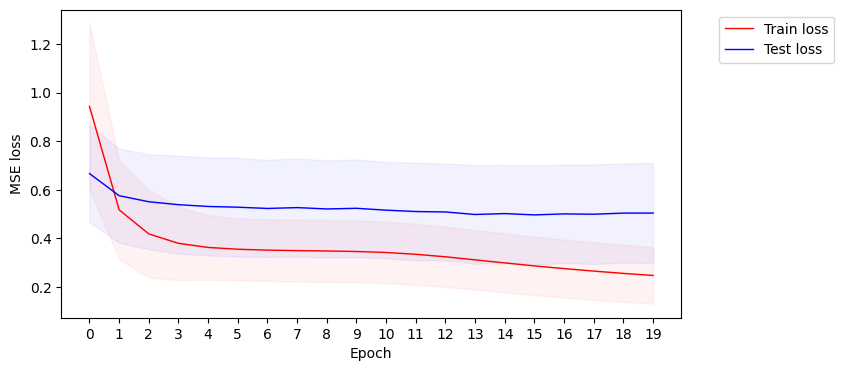

In [18]:
epochs_list = np.arange(epochs)
mean_train_loss = np.mean(train_loss_list, axis=1)
std_train_loss = np.std(train_loss_list, axis=1)
std_low_train_loss = mean_train_loss - std_train_loss
std_high_train_loss = mean_train_loss + std_train_loss

mean_test_loss = np.mean(test_loss_list, axis=1)
std_test_loss = np.std(test_loss_list, axis=1)
std_low_test_loss = mean_test_loss - std_test_loss
std_high_test_loss = mean_test_loss + std_test_loss

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(mean_train_loss, c='r', label='Train loss', linewidth=1.0)
axs.fill_between(epochs_list, mean_train_loss, std_low_train_loss, color='r', alpha=.05)
axs.fill_between(epochs_list, mean_train_loss, std_high_train_loss, color='r', alpha=.05)
plt.plot(mean_test_loss, c='b', label='Test loss', linewidth=1.0)
axs.fill_between(epochs_list, mean_test_loss, std_low_test_loss, color='b', alpha=.05)
axs.fill_between(epochs_list, mean_test_loss, std_high_test_loss, color='b', alpha=.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.xticks(np.arange(epochs_list.min(), epochs_list.max()+1, 1.0))
plt.show()

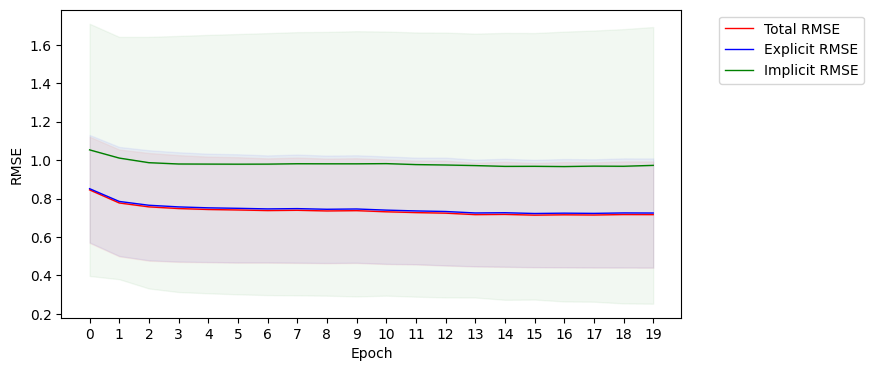

In [19]:
rmse_total_list = torch.vstack(rmse_total_list)
mean_rmse_total = torch.mean(rmse_total_list, dim=1)
std_rmse_total = torch.std(rmse_total_list, dim=1)
std_low_rmse_total = mean_rmse_total - std_rmse_total
std_high_rmse_total = mean_rmse_total + std_rmse_total

rmse_explicit_list = torch.vstack(rmse_explicit_list)
mean_rmse_explicit = torch.mean(rmse_explicit_list, dim=1)
std_rmse_explicit = torch.std(rmse_explicit_list, dim=1)
std_low_rmse_explicit = mean_rmse_explicit - std_rmse_explicit
std_high_rmse_explicit = mean_rmse_explicit + std_rmse_explicit

rmse_implicit_list = torch.vstack(rmse_implicit_list)
mean_rmse_implicit = torch.mean(rmse_implicit_list, dim=1)
std_rmse_implicit = torch.std(rmse_implicit_list, dim=1)
std_low_rmse_implicit = mean_rmse_implicit - std_rmse_implicit
std_high_rmse_implicit = mean_rmse_implicit + std_rmse_implicit

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(mean_rmse_total, c='r', label='Total RMSE', linewidth=1.0)
axs.fill_between(epochs_list, mean_rmse_total, std_low_rmse_total, color='r', alpha=.05)
axs.fill_between(epochs_list, mean_rmse_total, std_high_rmse_total, color='r', alpha=.05)
plt.plot(mean_rmse_explicit, c='b', label='Explicit RMSE', linewidth=1.0)
axs.fill_between(epochs_list, mean_rmse_explicit, std_low_rmse_explicit, color='b', alpha=.05)
axs.fill_between(epochs_list, mean_rmse_explicit, std_high_rmse_explicit, color='b', alpha=.05)
plt.plot(mean_rmse_implicit, c='g', label='Implicit RMSE', linewidth=1.0)
axs.fill_between(epochs_list, mean_rmse_implicit, std_low_rmse_implicit, color='g', alpha=.05)
axs.fill_between(epochs_list, mean_rmse_implicit, std_high_rmse_implicit, color='g', alpha=.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.xticks(np.arange(epochs_list.min(), epochs_list.max()+1, 1.0))
plt.show()

# Profile building

In [20]:
# Profile building for the users of the train set. 
N = len(train_seq_base_data)
idxs = list(range(N))
train_seq_base_profiles = []
for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
    end_idx = min(start_idx + batch_size, N)
    batch_train_data = train_base_data[idxs[start_idx:end_idx]]
    batch_train_seq_data = train_seq_base_data[idxs[start_idx:end_idx]]

    batch_user_data = []
    for i in range(len(batch_train_seq_data)):
        user = int(batch_train_seq_data[i][0].item())
        user_data = []
        for category in range(n_categories):
            user_data.append([user, category])
        user_data = torch.tensor(user_data).to(device)
        batch_user_data.append(user_data)
    batch_user_data = torch.vstack(batch_user_data).to(device)
    
    batch_recon_data = model(batch_user_data)
    batch_recon_data = torch.reshape(batch_recon_data.detach(), (len(batch_train_seq_data), n_categories)).to(device)
    train_seq_base_profiles.append(batch_recon_data)
train_seq_base_profiles = torch.vstack(train_seq_base_profiles).to(device)
train_seq_base_profiles = train_seq_base_profiles.numpy()

# Profile building for the users of the test set.
N = len(test_seq_base_data)
idxs = list(range(N))
test_seq_base_profiles = []
for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
    end_idx = min(start_idx + batch_size, N)
    batch_test_data = test_base_data[idxs[start_idx:end_idx]]
    batch_test_seq_data = test_seq_base_data[idxs[start_idx:end_idx]]

    batch_user_data = []
    for i in range(len(batch_test_seq_data)):
        user = int(batch_test_seq_data[i][0].item())
        user_data = []
        for category in range(n_categories):
            user_data.append([user, category])
        user_data = torch.tensor(user_data).to(device)
        batch_user_data.append(user_data)
    batch_user_data = torch.vstack(batch_user_data).to(device)
    
    batch_recon_data = model(batch_user_data)
    batch_recon_data = torch.reshape(batch_recon_data.detach(), (len(batch_test_seq_data), n_categories)).to(device)
    test_seq_base_profiles.append(batch_recon_data)
test_seq_base_profiles = torch.vstack(test_seq_base_profiles).to(device)
test_seq_base_profiles = test_seq_base_profiles.numpy()

dataframe_train_seq_base_profiles = pd.DataFrame(train_seq_base_profiles)
dataframe_train_seq_base_profiles.to_csv(f"{dataset.dataset_path}/preprocessed/train_profiles_mf_predict_win.csv", index=False)
dataframe_test_seq_base_profiles = pd.DataFrame(test_seq_base_profiles)
dataframe_test_seq_base_profiles.to_csv(f"{dataset.dataset_path}/preprocessed/test_profiles_mf_predict_win.csv", index=False)